# Naive Risk Budgeting Strategies between the PSP and GHP

In [1]:
from sys import path 
path.append('../')
import edhec_risk_kit as erk 

import pandas as pd 
import numpy as np 

import ipywidgets as widgets
from IPython.display import display

%load_ext autoreload 
%autoreload 2

In [2]:
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError('r1 and r2 need to be the same shape')
    
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError('allocator returned weights that do not match r1')
    
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

In [3]:
def fixed_mix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
     each column is a scenario
     each row is the price for a timestep
    Returns an T x N DataFrame of PSP Weights
    """

    return pd.DataFrame(data=w1, index=r1.index, columns=r1.columns)

In [5]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0=0.03)
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, 0.05, 12)
rets_10 = erk.bond_total_return(price_10, 100, 0.05, 12)
rets_bonds = erk.bt_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.035316,0.004204,-0.192699,2.943935,-0.000843,-0.000165,1.230748,-0.000416


In [7]:
price_eq = erk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()  # can only do it with a zero coupon bond

In [9]:
rets_7030b = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=0.7)  # 70% in the PSP 
rets_7030b_mean = rets_7030b.mean(axis='columns')
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.059972,0.004681,0.066814,2.477327,-0.002664,-0.002279,6.231596,0.0


In [10]:
# instead of averaging and then getting summary stats, compute summary stats on each of the scenarios 
summaries = erk.summary_stats(rets_7030b)

In [11]:
summaries.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.020445,0.110194,0.338083,3.449481,0.046519,0.059028,-0.084527,-0.193242
1,0.033421,0.107273,0.190187,2.960579,0.045844,0.056374,0.030908,-0.162932
2,0.025451,0.098577,-0.160172,2.735504,0.045541,0.057826,-0.045038,-0.191531
3,0.071658,0.103609,0.352413,2.642497,0.039931,0.043462,0.391214,-0.113769
4,0.018216,0.105466,-0.210831,2.844431,0.049789,0.064904,-0.108874,-0.292536


In [12]:
# now get the mean of all the scenarios
summaries.mean()

Annualized Return          0.054573
Annualized Vol             0.107155
Skewness                   0.013368
Kurtosis                   2.940232
Cornish-Fisher VaR (5%)    0.045695
Historic CVaR (5%)         0.057576
Sharpe Ratio               0.224631
Max Drawdown              -0.205799
dtype: float64

In [13]:
def terminal_values(rets):
    """
    Returns the final values of a dollar at the end of the return period for each scenario
    """
    return (rets+1).prod()

In [14]:
pd.concat([
    erk.terminal_stats(rets_bonds, name='FI'),
    erk.terminal_stats(rets_eq, name='Eq'),
    erk.terminal_stats(rets_7030b, name='70/30')
], axis=1)

# What can we do to make sure we hit that liability (eliminate e_short in 70/30 split)

,FI,Eq,70/30
mean,1.376951,1.994075,1.793297
std,0.117181,0.962339,0.610574
p_breach,NaN,0.072000,0.022000
e_short,NaN,0.131659,0.068580
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level functi

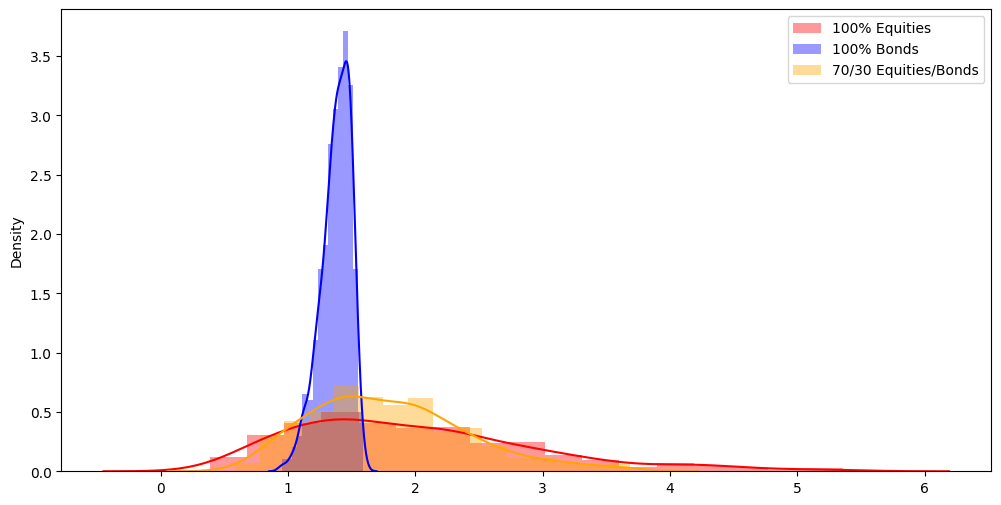

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend();

# Glide Paths for Allocation

In [16]:
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0):
    """
    Simulates a target-date-fund style gradual move from r1 to r2
    """
    n_points = r1.shape[0]  # number of rows 
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis='columns')
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [18]:
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=.8, end_glide=.2)
pd.concat([
    erk.terminal_stats(rets_bonds, name='FI'),
    erk.terminal_stats(rets_eq, name='Eq'),
    erk.terminal_stats(rets_7030b, name='70/30'),
    erk.terminal_stats(rets_g8020, name='Glide 80 to 20')  # still get breaches in e_short
], axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.376951,1.994075,1.793297,1.673879
std,0.117181,0.962339,0.610574,0.453714
p_breach,NaN,0.072000,0.022000,0.004000
e_short,NaN,0.131659,0.068580,0.054139
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN
